# Downloading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

# ==== Paths ====
train_dir = '/content/drive/MyDrive/VGG/train'
val_dir   = '/content/drive/MyDrive/VGG/valid'
test_dir  = '/content/drive/MyDrive/VGG/test'

# ==== Parameters ====
img_size = (256, 256)  # 🔻 Reduced from 512x512
batch_size = 16        # 🔻 Reduced from 256
seed = 123

# ==== Load Datasets ====
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Optional: Normalize using EfficientNet’s preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 3200 files belonging to 2 classes.
Found 398 files belonging to 2 classes.
Found 402 files belonging to 2 classes.


In [ ]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=seed,
    color_mode='rgb',
    image_size=img_size,
    batch_size=train_batch_size
)

# ✅ Print class names before prefetch
print("Class names:", train_ds.class_names)

# Then continue with prefetching
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)


Found 3200 files belonging to 2 classes.
Class names: ['defect', 'normal']


In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(256, 512, 512, 3)
(256,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preparing model for training

In [ ]:

num_classes=2

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

def se_block(inputs, ratio=8):
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.Multiply()([inputs, se])

def transformer_encoder(inputs, num_heads=2, ff_dim=256, dropout_rate=0.1):
    x1 = layers.LayerNormalization()(inputs)
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1] // num_heads)(x1, x1)
    x2 = layers.Add()([inputs, attn_output])
    x3 = layers.LayerNormalization()(x2)
    ffn = layers.Dense(ff_dim, activation='gelu')(x3)
    ffn = layers.Dense(inputs.shape[-1])(ffn)
    return layers.Add()([x2, ffn])

def build_hybrid_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)
    backbone = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')
    feat_small = backbone.get_layer('block3a_expand_activation').output
    feat_large = backbone.get_layer('block4a_expand_activation').output

    xB = layers.Conv2D(96, 1, activation='swish')(feat_small)
    xB = layers.MaxPooling2D(2)(xB)
    xB = se_block(xB)
    xA = se_block(feat_large)

    x = layers.Concatenate()([xA, xB])
    x = layers.Conv2D(192, 1, activation='swish')(x)
    h, w, c = x.shape[1], x.shape[2], x.shape[3]

    x_flat = layers.Reshape((h*w, c))(x)
    pos_embed = tf.Variable(tf.random.normal([1, h*w, c]), trainable=True)
    x_flat = layers.Add()([x_flat, pos_embed])

    for _ in range(2):  # 🔻 Reduced to 2 transformer blocks
        x_flat = transformer_encoder(x_flat, num_heads=2, ff_dim=256)

    x = layers.Reshape((h, w, c))(x_flat)
    x = layers.SeparableConv2D(192, 3, padding='same', activation='swish')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='gelu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    return models.Model(inputs, outputs)


In [ ]:
model = build_hybrid_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 721,604 (2.75 MB)

 Trainable params: 718,205 (2.74 MB)

 Non-trainable params: 3,399 (13.28 KB)

In [ ]:
model = build_hybrid_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)
]


## Start training and validating results

In [ ]:
n_epoch = 100

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6622 - loss: 0.5983
Epoch 1: val_accuracy improved from -inf to 0.76382, saving model to best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.6625 - loss: 0.5980 - val_accuracy: 0.7638 - val_loss: 0.4624 - learning_rate: 0.0010
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8549 - loss: 0.3299
Epoch 2: val_accuracy improved from 0.76382 to 0.82161, saving model to best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 65s 165ms/step - accuracy: 0.8550 - loss: 0.3297 - val_accuracy: 0.8216 - val_loss: 0.3769 - learning_rate: 0.0010
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9188 - loss: 0.2011
Epoch 3: val_accuracy improved from 0.82161 to 0.95226, saving model to best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.9188 - loss: 0.2010 - val_accuracy: 0.9523 - val_loss: 0.1263 - learning_rate: 0.0010
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9450 - loss: 0.1510
Epoch 4: val_accuracy did not improve from 0.95226
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 160ms/step - accuracy: 0.9450 - loss: 0.1509 - val_accuracy: 0.9095 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9511 - loss: 0.1243
Epoch 5: val_accuracy improved from 0.95226 to 0.95477, saving model to best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.9512 - loss: 0.1243 - val_accuracy: 0.9548 - val_loss: 0.1152 - learning_rate: 0.0010
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9651 - loss: 0.0964
Epoch 6: val_accuracy improved from 0.95477 to 0.96231, saving model to best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.9651 - loss: 0.0964 - val_accuracy: 0.9623 - val_loss: 0.1166 - learning_rate: 0.0010
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9807 - loss: 0.0541
Epoch 7: val_accuracy did not improve from 0.96231
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.9807 - loss: 0.0541 - val_accuracy: 0.9246 - val_loss: 0.1843 - learning_rate: 0.0010
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9779 - loss: 0.0692
Epoch 8: val_accuracy did not improve from 0.96231

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.9779 - loss: 0.0691 - val_accuracy: 0.9497 - val_loss: 0.1702 - learning_rate: 0.0010
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9833 - loss: 0.0510
Epoch 9: val_accuracy improved from 0.96231 to 0.98241, saving model to best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 163ms/step - accuracy: 0.9833 - loss: 0.0510 - val_accuracy: 0.9824 - val_loss: 0.0623 - learning_rate: 5.0000e-04
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9934 - loss: 0.0237
Epoch 10: val_accuracy did not improve from 0.98241
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 148ms/step - accuracy: 0.9934 - loss: 0.0238 - val_accuracy: 0.9824 - val_loss: 0.0598 - learning_rate: 5.0000e-04
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9913 - loss: 0.0212
Epoch 11: val_accuracy did not improve from 0.98241
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - accuracy: 0.9913 - loss: 0.0211 - val_accuracy: 0.9774 - val_loss: 0.0956 - learning_rate: 5.0000e-04
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9959 - loss: 0.0174
Epoch 12: val_accuracy improved from 0.98241 to 0.98492, saving model to best_model.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 44s 162ms/step - accuracy: 0.9959 - loss: 0.0174 - val_accuracy: 0.9849 - val_loss: 0.0993 - learning_rate: 5.0000e-04
Epoch 13/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9947 - loss: 0.0192
Epoch 13: val_accuracy did not improve from 0.98492

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.9947 - loss: 0.0192 - val_accuracy: 0.9774 - val_loss: 0.0723 - learning_rate: 5.0000e-04
Epoch 14/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9880 - loss: 0.0283
Epoch 14: val_accuracy did not improve from 0.98492
200/200 ━━━━━━━━━━━━━━━━━━━━ 42s 164ms/step - accuracy: 0.9881 - loss: 0.0282 - val_accuracy: 0.9799 - val_loss: 0.0954 - learning_rate: 2.5000e-04
Epoch 15/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9992 - loss: 0.0052
Epoch 15: val_accuracy did not improve from 0.98492
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 160ms/step - accuracy:

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('best_model.h5')  # This automatically loads weights and structure


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

print(f"\n📊 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.2%}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 154s 6s/step - accuracy: 0.9910 - loss: 0.0350

📊 Test Loss: 0.0304
✅ Test Accuracy: 98.76%


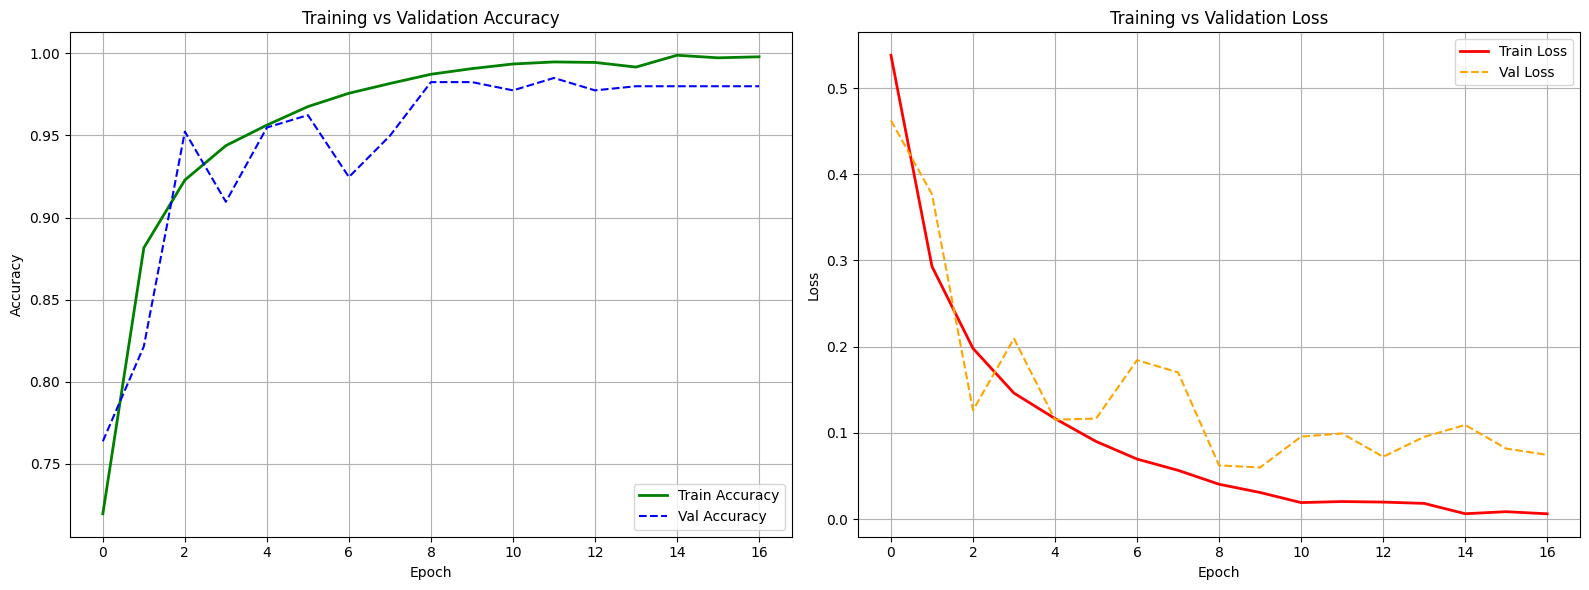

In [ ]:
import matplotlib.pyplot as plt

# ✅ Use actual number of epochs from history
epochs_range = range(len(history.history['accuracy']))

# Extract metrics
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

# Plot
plt.figure(figsize=(16, 6))

# 🔹 Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', color='green', linewidth=2)
plt.plot(epochs_range, val_acc, label='Val Accuracy', color='blue', linestyle='--')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# 🔸 Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', color='red', linewidth=2)
plt.plot(epochs_range, val_loss, label='Val Loss', color='orange', linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()
